Импорт библиотек

In [1]:
from typing import Optional, Tuple, Literal, Iterable
from abc import abstractmethod, ABC
import copy
import torch
from torch import Tensor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from src.nn import BayesianModule, BayesianLinear, BayesianSequential, BayesianBinaryClassifier

Чтение данных и разбиение на трейн и тест

In [2]:
df = pd.read_csv("data/Cancer_Data.csv").set_index("id")
df = df.loc[:, df.notna().all(axis=0)]
df["is_M"] = (df["diagnosis"] == "M").astype("int")
df = df.drop("diagnosis", axis=1)
x = df.drop("is_M", axis=1)
y = df["is_M"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

Обучение модели

In [3]:
x_train_tensor = torch.from_numpy(x_train.values).float().cuda()
y_train_tensor = torch.from_numpy(y_train.values).view(-1, 1).float().cuda()

epoch
0      381469.343750
1      270675.687500
2      153551.203125
3      411188.843750
4      223224.234375
           ...      
995     31681.498047
996     32552.642578
997     31085.779297
998     29570.384766
999     31424.996094
Name: kl, Length: 1000, dtype: float64

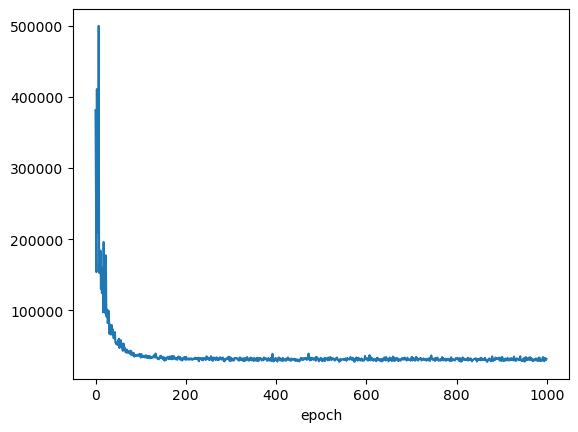

In [4]:
model = BayesianBinaryClassifier(
    dim_in=x_train.shape[-1],
    dim_hidden=30,
    n_layers=3,
    lr=0.01,
    f_act="LeakyReLU",
    backbone="Perceptrone",
).cuda()
model.scale_shift_init(x=x_train_tensor)
model.init(x=x_train_tensor, num_epoch=1_000)
model.init_mode_off()
model.df_metrics["kl"].plot()
model.df_metrics["kl"].dropna()

,kl,loss,p_item_average
epoch,,,
0,381469.343750,NaN,NaN
1,270675.687500,NaN,NaN
2,153551.203125,NaN,NaN
3,411188.843750,NaN,NaN
4,223224.234375,NaN,NaN
...,...,...,...
30995,NaN,0.116504,0.890026
30996,NaN,0.162343,0.850150
30997,NaN,0.119108,0.887712


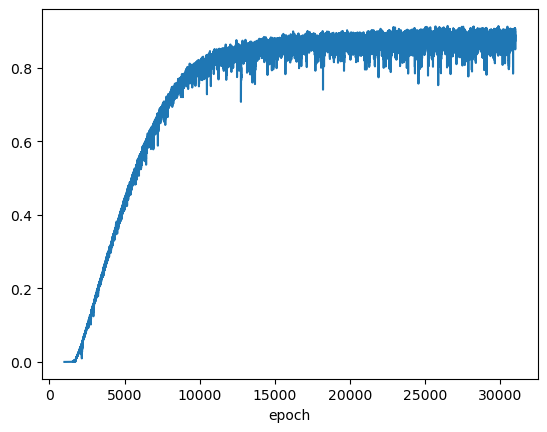

In [5]:
model.fit(
    x=x_train_tensor,
    y=y_train_tensor,
    num_epoch=30_000,
)
model.df_metrics["p_item_average"].plot()
model.df_metrics

Предсказание на тесте.
Каждый объект прогоняется через модель 5000

In [6]:
model = model.eval().cpu()
x_test_tensor = torch.from_numpy(x_test.values).float()
y_test_tensor = torch.from_numpy(y_test.values).view(-1, 1).float()

y_pred_test_tensor = torch.nn.Sigmoid()(model(x_test_tensor.expand(5000, *x_test_tensor.shape)))
y_pred_test = y_pred_test_tensor.cpu().detach().numpy()

Оценка результата работы на тесте

In [7]:
((y_pred_test.mean(axis=0).reshape(-1) > 0.5).astype("int") == y_test).sum() / len(y_test)

np.float64(0.9649122807017544)

Сравнение модели со случайным лесом

In [8]:
model_forest = RandomForestClassifier(n_estimators=500)
model_forest.fit(X=x_train, y=y_train)
y_pred_test_forest = model_forest.predict(X=x_test)

(y_pred_test_forest == y_test).sum() / len(y_test)

np.float64(0.956140350877193)

Сравнение модели с бустингом

In [9]:
model_boost = GradientBoostingClassifier()
model_boost.fit(X=x_train, y=y_train)
y_pred_test_boost = model_boost.predict(X=x_test)

(y_pred_test_boost == y_test).sum() / len(y_test)

np.float64(0.9736842105263158)

Сравнение модели с перцептроном

In [10]:
model_mlp = MLPClassifier(hidden_layer_sizes=[10, 10, 10, 10], activation="relu", max_iter=1000)
model_mlp.fit(X=x_train, y=y_train)
y_pred_test_mlp = model_mlp.predict(X=x_test)

(y_pred_test_mlp == y_test).sum() / len(y_test)

np.float64(0.9210526315789473)